In [104]:
import numpy as np
from mikeio import Dfsu, Mesh

# DURING DEVELOPMENT ONLY
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
filename = "../tests/testdata/oresund_sigma_z.dfsu"
dfs = Dfsu(filename)
dfs

Dfsu3DSigmaZ
Number of elements: 17118
Number of nodes: 12042
Projection: UTM-33
Number of sigma layers: 4
Max number of z layers: 5
Number of items: 3
Time: 3 steps with dt=10800.0s
      1997-09-15 21:00:00 -- 1997-09-16 03:00:00

In [107]:
dfs.items

[Z coordinate <ItemGeometry3D> (meter),
 Temperature <Temperature> (degree Celsius),
 Salinity <Salinity> (PSU)]

In [108]:
elem_ids = dfs.bottom_element_ids
print(elem_ids[:10])
print(dfs.top_element_ids[:10])

[ 0  5  9 13 17 21 25 29 33 37]
[ 4  8 12 16 20 24 28 32 36 40]


In [109]:
geom = dfs.elements_to_geometry(elem_ids, node_layers='bottom')
geom

Unstructured Geometry
Number of nodes: 2820
Number of elements: 3700
Number of layers: 6
Projection: UTM-33

In [110]:
ze = geom.element_coordinates[:,2]
ze.min()

-33.0

## Save bottom layer to new mesh file

In [122]:
Mesh.geometry_to_mesh("../tests/testdata/mesh_oresund_extracted.mesh", geom)

## Evaluate top layer

In [112]:
elem_ids = dfs.top_element_ids

In [113]:
ds = dfs.read(element_ids=elem_ids)
print(ds)
max_t = ds['Temperature'].max()
print(f'Maximum temperature in top layer: {max_t:.1f}')

<mikeio.DataSet>
Dimensions: (3, 3700)
Time: 1997-09-15 21:00:00 - 1997-09-16 03:00:00
Items:
  0:  Z coordinate <ItemGeometry3D> (meter)
  1:  Temperature <Temperature> (degree Celsius)
  2:  Salinity <Salinity> (PSU)
Maximum temperature in top layer: 17.5


# Select top elements of a smaller area

In [114]:
eid = dfs.top_element_ids
xc = dfs.element_coordinates[eid,0]
yc = dfs.element_coordinates[eid,1]

In [115]:
mask = (yc>6192000)*(yc<6198000)
elem_ids = eid[mask]
len(elem_ids)

118

In [116]:
ds_sub = dfs.read(element_ids=elem_ids)
ds_sub

<mikeio.DataSet>
Dimensions: (3, 118)
Time: 1997-09-15 21:00:00 - 1997-09-16 03:00:00
Items:
  0:  Z coordinate <ItemGeometry3D> (meter)
  1:  Temperature <Temperature> (degree Celsius)
  2:  Salinity <Salinity> (PSU)

In [117]:
geom = dfs.elements_to_geometry(elem_ids, node_layers='top')
geom

Unstructured Geometry
Number of nodes: 87
Number of elements: 118
Projection: UTM-33

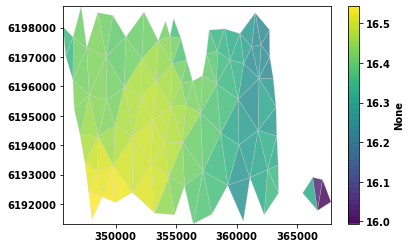

In [120]:
geom.plot(z=ds_sub.data[1][0,:])

In [121]:
dfs.write("../tests/testdata/oresund_data_extracted.dfsu", ds_sub, element_ids=elem_ids)

will redo extraction in 2d!
